In [53]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [54]:
sns.set_style("darkgrid")
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [55]:
data = pd.read_csv("../data/data.csv")

In [56]:
data.head()

,Customer,Type,Text,Summary
0,Notion,Appstore/Playstore,User: The app doesn't send sound or vibration ...,User finds the app useless without sound or vi...
1,Notion,Appstore/Playstore,"User: This app changed my life, I can only say...","User praises the app, stating it has changed t..."
2,Notion,Appstore/Playstore,User: Have you ever experienced this situation...,NaN
3,Notion,Appstore/Playstore,User: Mass editing a table/database is so slow...,User finds Notion's mass editing feature slow ...
4,Notion,Appstore/Playstore,User: the only concern is that it doesn't work...,User is concerned about the product not workin...


In [57]:
data.shape

(5009, 4)

In [58]:
data.isna().sum()

Customer       0
Type           0
Text           0
Summary     1008
dtype: int64

In [59]:
print(data[data['Summary'].isna()])

     Customer                Type   
2      Notion  Appstore/Playstore  \
8      Notion  Appstore/Playstore   
15     Notion  Appstore/Playstore   
17     Notion  Appstore/Playstore   
18     Notion  Appstore/Playstore   
...       ...                 ...   
5004     zoom  Appstore/Playstore   
5005     zoom  Appstore/Playstore   
5006     zoom  Appstore/Playstore   
5007     zoom  Appstore/Playstore   
5008     zoom  Appstore/Playstore   

                                                   Text Summary  
2     User: Have you ever experienced this situation...     NaN  
8     User: I HAD SUCH A LONG NOTION PAGES AND MY AC...     NaN  
15          User: The only place to put your “Notes-On”     NaN  
17                                   User: Can't use AI     NaN  
18                                User: Spanish please!     NaN  
...                                                 ...     ...  
5004                       User: Not so important......     NaN  
5005                       

In [60]:
# we want even such samples in training. So replace Summary with "None"
data['Summary'].fillna("None", inplace = True)

In [61]:
data.isna().sum()

Customer    0
Type        0
Text        0
Summary     0
dtype: int64

In [62]:
data['text_length'] = data['Text'].apply(lambda text: len(text.split()))
data['summary_length'] = data['Summary'].apply(lambda summary: len(summary.split()))
data['sum_text_ratio'] = data['summary_length'] / data['text_length']

Text(0.5, 1.0, 'Ratio of summary to text length')

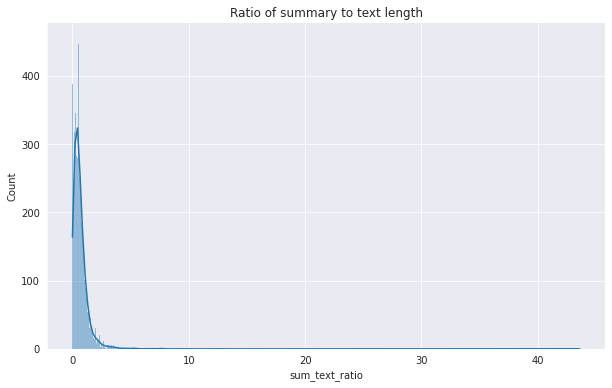

In [63]:
# some summaries are larger than the text
sns.histplot(data['sum_text_ratio'], kde = True)
plt.title("Ratio of summary to text length")

In [64]:
print("Original Text: ", data[data['sum_text_ratio'] > 10].reset_index(drop = True)['Text'][0])
print("Summary: ", data[data['sum_text_ratio'] > 10].reset_index(drop = True)['Summary'][0])

Original Text:  User: Pretty! 💙
@browsercompany <STRICT_LINK>
Summary:  User: I'm not sure if I'm the only one who's having this issue, but I'm having a problem with the browserco app. I can't get it to open. I've tried restarting my phone, restarting the app, and even restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app 

In [65]:
print(data[data['sum_text_ratio'] > 5].index)

Index([ 753, 1957, 1959, 2013, 2036, 2074, 2175, 2186, 2187, 2231, 2254, 2390,
       2546, 2694, 2698, 2942, 3112, 3375, 3382, 3706, 3799],
      dtype='int64')


In [66]:
# Some examples: 

# // Need to extract only summary from such examples. 
# // Summary is irrelevant to the Text
# Text: User: Where is the Arabic language thanks 
# Summary:  
# Product: Notion
# Feedbacktype: RecordTypeReview
# Review Content: User: I love it
# Summary:
# User loves the product.

# // Summary is irrelevant to the Text
# Text: User: Spanish - Spanish
# Summary: 
# Review Content: User: I love it
# Summary:
# User loves the product.

# Text: User: 123
# Summary:
# Review Content: User: 123
# Summary:
#  None

# // Different language
# Text: User: iPhoneとiPadだと日本語でタイトル入力すると消える！
# Summary: User experiences issues with the app on iPhone and iPad, where the title input disappears when using Japanese.

# // Twitter content that cant be inferred without strict link
# Text: User: This week's @NotionHQ content is brought to you by: matcha <STRICT_LINK>
# Summary: User shares a link to a Notion article about the importance of a good night's sleep and mentions that they are going to try out the Notion app.

# Text: User: .@NotionHQ kidding? <STRICT_LINK>
# Summary: User is excited about the new Notion app and is looking forward to using it.

# // Couple of words expanded to sentence in summary
# Text: User: Network issue
# Summary: User experienced network issues while using Zoom.


# Upon browsing twitter text, it seems like the summary of twitter text is the most unobvious. Sometimes can't even be summarized without knowing the content of Strict_Link

In [67]:
# preprocess text to remove strict_links and emojis. 
# Don't remove @ and # because the user might have tweeted as: Good feature by @Enterpret, @Notion always crash. Here without mentions, it would be impossible to know the good review is for which product and the bad review for which
# Dont remove hastag because some people tweet: #excited #lovedit etc. which can help know the intent of review

def preprocess_text(text):

    # Remove strict links
    text = re.sub(r'https?:\/\/\S+', '', text)

    # Remove emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251" 
        "]+"
    )
    text = emoji_pattern.sub('', text)

    # Remove any remaining special characters or punctuations
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace("STRICT_LINK", "")

    return text

In [68]:
example = data[data['Type'] == "Twitter"]['Text'][997]
processed_text = preprocess_text(example)
print("Original text: ", example)
print("Processed text: ", processed_text)

Original text:  User: This week's @NotionHQ content is brought to you by: matcha <STRICT_LINK>
Processed text:  User This weeks NotionHQ content is brought to you by matcha 


In [69]:
# apply on Text

data['Text'] = data['Text'].apply(preprocess_text)

In [70]:
# lets look at some "None" summaries

# Following is `Help` or `Complained` category
# 'User: Have you ever experienced this situation? The payment interface still pops up when you subscribe and then use it'

# `Help` category
# 'User: I HAD SUCH A LONG NOTION PAGES AND MY ACC GOT REMOVED FOR WHAT???? HELP'

# `Praise` category
# 'User: The only place to put your “Notes-On”'

# `Praise` category
# 'User: Best app...'

# We may remove it from the first iteration of training, then predict on them with the first trained model and use it for training again

# thats a significant about of None content
len(data[data['Summary'] == "None"])

# Observed that if the Text is very concise < 3-4 words and is a positive review, then Summary is "None". THey should have been summarised under the `Praise` intent

1008

In [71]:
# lets see if some summary is repeated multiple times

data['Summary'].value_counts().head(5)

Summary
None                                                                                                                                                          1008
User is excited about the new Notion app and is looking forward to using it.                                                                                   274
User is excited about the new features in Notion and is looking forward to using them.                                                                          37
\n None                                                                                                                                                         36
User is excited about the new features in the latest version of BrowserCO, including the ability to add a custom logo and customize the color of the logo.      31
Name: count, dtype: int64

In [72]:
# replace `\n None` with `None`
data['Summary'] = data['Summary'].replace("\n None", "None")

In [73]:
data['Summary'].value_counts().head(5)

Summary
None                                                                                                                                                          1044
User is excited about the new Notion app and is looking forward to using it.                                                                                   274
User is excited about the new features in Notion and is looking forward to using them.                                                                          37
User is excited about the new features in the latest version of BrowserCO, including the ability to add a custom logo and customize the color of the logo.      31
User is excited about the new Notion features and is looking forward to using them.                                                                             25
Name: count, dtype: int64

In [74]:
# lets see if any text is repeated

data['Text'].value_counts().head(5)

Text
User RT AdhamDannaway  Learn Design\nA free course by Figma to help you get started in design\n 12 lessons\n 5 Exercises\n Practice files                                                                                                                                                             37
User                                                                                                                                                                                                                                                                                                  25
User RT Alex_FigmaEdu Teachers We have lots of DonorsChoose funding love left to share Drop your project link below to share with the Fig                                                                                                                                                             20
User RT zander_supafast Documenting Design Systems in figma supafast                                    

In [75]:
most_repeated = data['Text'].value_counts().index[0]
# the repeated text is for the same product. Need do remove duplicates
data[data['Text'] == most_repeated]

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio
3302,figma,Twitter,User RT AdhamDannaway Learn Design\nA free co...,User shares a quick experiment in Figma to cr...,27,23,0.851852
3366,figma,Twitter,User RT AdhamDannaway Learn Design\nA free co...,User shares a project aimed at helping over 9...,27,26,0.962963
3449,figma,Twitter,User RT AdhamDannaway Learn Design\nA free co...,User Alex FigmaEdu is looking for DonorsChoos...,27,22,0.814815
3451,figma,Twitter,User RT AdhamDannaway Learn Design\nA free co...,None,27,1,0.037037
3496,figma,Twitter,User RT AdhamDannaway Learn Design\nA free co...,User shared a list of design system tools they...,27,19,0.703704
3535,figma,Twitter,User RT AdhamDannaway Learn Design\nA free co...,User is in a 30-day free trial period of using...,27,25,0.925926
3537,figma,Twitter,User RT AdhamDannaway Learn Design\nA free co...,User expresses disappointment with Figma's sup...,27,28,1.037037
3539,figma,Twitter,User RT AdhamDannaway Learn Design\nA free co...,User found a free mockup UI presentation for t...,27,16,0.592593
3561,figma,Twitter,User RT AdhamDannaway Learn Design\nA free co...,A user shared a list of 11 no-code tools for ...,27,64,2.370370
3605,figma,Twitter,User RT AdhamDannaway Learn Design\nA free co...,User finds adding MetricsCard to their design ...,27,23,0.851852


In [76]:
# In Falcon paper, they had a de-duplication process. So lets de-duplicate.

data = data.drop_duplicates(subset = "Text", keep="first")

In [77]:
# No duplicates in Text
print("Count of Text")
print(data['Text'].value_counts().head(5))
print("Count of Summaries")
print(data['Summary'].value_counts().head(5))

Count of Text
Text
User The app doesnt send sound or vibration notifications which makes this feature almost useless on the iPhone                                                                                                                                                                                                                                                                                                                                                  1
User Todays FigmaJapan office \nIm surrounded by lots of dharma                                                                                                                                                                                                                                                                                                                                                                                                  1
User RT figma Figma is now available in Japanese \nWeve localized amp translate

In [78]:
data.shape

(4756, 7)

In [79]:
# All Text start with User. I think it is redundant. Lets remove it
data['Text'] = data['Text'].apply(lambda text: text.replace("User ", ""))

In [80]:
# // Need to extract only summary from such examples. 
# // Summary is irrelevant to the Text
# Text: User: Where is the Arabic language thanks 
# Summary:  
# Product: Notion
# Feedbacktype: RecordTypeReview
# Review Content: User: I love it
# Summary:
# User loves the product.

data['Summary'] = data['Summary'].apply(lambda summary: summary.split("Summary:")[-1])

In [81]:
# thus successfully extracted the summary
data[data['Summary'].str.contains("Summary:")]

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio


Text(0.5, 1.0, 'Ratio of summary to text length')

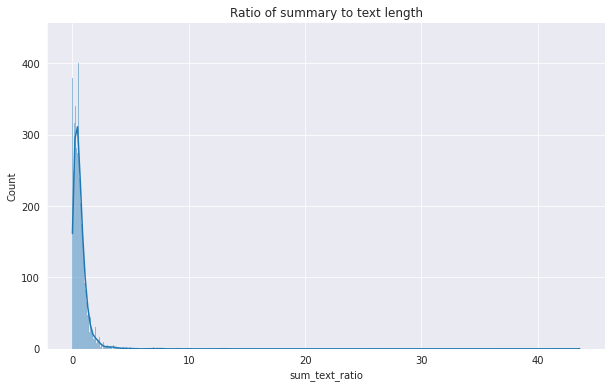

In [82]:
# lets see the graph again

sns.histplot(data['sum_text_ratio'], kde = True)
plt.title("Ratio of summary to text length")

In [83]:
# Such following examples cannot be summarized by just using the given text

# Text: 
# User: Pretty! 💙
# @browsercompany <STRICT_LINK>

# Summary:
# User: I'm not sure if I'm the only one who's having this issue, but I'm having a problem with the browserco app. I can't get it to open. I've tried restarting my phone, restarting the app, and even restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting m

# Text:
# User: @nick__pattison @figma That’s worrying.
# Summary:
# A user shared their DonorsChoose project for books about taking care of the Earth and suggested that students could use Figma's FigJam to collaborate on ideas and action plans based on their readings.

# Some summaries are not even related to the Text
# Text: 
# User: Why does @NotionHQ use a Somali domain?

# Summary:
# User is frustrated with the lack of updates on the Notion website and mentions that they have been waiting for a new feature for a long time.

# In some examples, the review doesn't look like it is of the mentioned product
# Text:
# User: Here’s an invite to Arc, the browser. Use it, you'll love it!
#arc @arcinternet <STRICT_LINK>
# Summary:
# User is excited about the new features in the latest version of Firefox, including the ability to create a new tab with a custom background and a new feature that allows users to create a new tab with a custom background and a new tab page.


# For a tweet to belong to the product, the product name has to be mentioned in the tweet. Or the mention (@). We can maybe check using this heuristic if the tweet even belongs to the product

# looking at some of the above texts, I believe the model will have less metric score on Twitter source.
print(list(data[data['sum_text_ratio'] > 2].index))

[62, 239, 242, 646, 753, 755, 997, 1003, 1018, 1162, 1224, 1309, 1387, 1414, 1433, 1464, 1497, 1549, 1688, 1719, 1752, 1758, 1847, 1901, 1923, 1945, 1954, 1957, 1959, 1967, 1972, 2013, 2028, 2036, 2041, 2058, 2072, 2074, 2081, 2129, 2141, 2158, 2175, 2194, 2231, 2254, 2258, 2296, 2299, 2308, 2318, 2352, 2359, 2383, 2386, 2396, 2405, 2414, 2415, 2423, 2442, 2445, 2451, 2472, 2483, 2494, 2504, 2517, 2518, 2524, 2533, 2546, 2556, 2596, 2607, 2644, 2648, 2669, 2680, 2694, 2698, 2701, 2702, 2704, 2706, 2714, 2755, 2779, 2793, 2799, 2821, 2831, 2861, 2867, 2873, 2892, 2893, 2911, 2924, 2936, 2942, 2944, 2956, 2962, 2979, 3090, 3112, 3221, 3335, 3375, 3411, 3446, 3457, 3485, 3521, 3552, 3569, 3649, 3672, 3695, 3705, 3754, 3762, 3862, 3897, 4074, 4143, 4169, 4388, 4402, 4412, 4461, 4475, 4490, 4525, 4535, 4543, 4604, 4614, 4622, 4631, 4637, 4647, 4700, 4727, 4840, 4913, 4979, 5001]


In [84]:
# even while reading some G2 text and summary, they dont seem related to each other. 

# Text:
# User: I use Figjam to get alignment on key initiatives and work through brainstorming sessions.
# User: Easy to use and flexible for all my needs.
# User: Can be hard to give access to others and sometimes it doesnt work

# Summary:
# Users appreciate Miro's ability to facilitate synchronous and asynchronous brainstorming, as well as its wide range of templates for visualizing ideas and requirements. However, they note that it requires a good internet connection and lacks features like hatched backgrounds, compared to lighter tools like Excalidraw.

# There are many instances like above

# lets find the semantic similarity between the summary and text. 
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_sim_score(row):
    #Compute embedding for both lists
    embeddings1 = model.encode(row["Text"], convert_to_tensor=True)
    embeddings2 = model.encode(row["Summary"], convert_to_tensor=True)
    #Compute cosine-similarities
    cosine_score = util.cos_sim(embeddings1, embeddings2)
    return cosine_score.item()

data['sim_score'] = data.apply(get_sim_score, axis = 1)

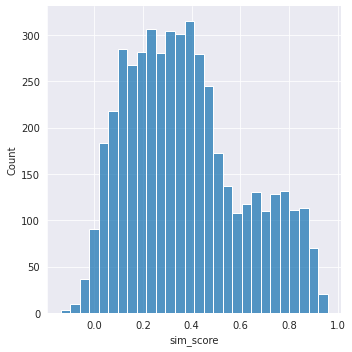

In [85]:
sns.displot(data['sim_score'], kind = "hist")

In [86]:
# need to replace "\n" with "None"
data[(data['sim_score'] < 0.2) & (data['Summary'] != "None") & (data['text_length'] > 4)]

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score
239,Notion,Appstore/Playstore,Where is the Arabic language thanks,\nUser loves the product.,7,15,2.142857,0.053784
503,Notion,Appstore/Playstore,It does not go anywhere except the menu,\n,9,0,0.000000,0.028111
509,Notion,Appstore/Playstore,Its still loading and the screen doesnt pop up,\n,10,0,0.000000,0.083069
552,Notion,Appstore/Playstore,Please fix some errors,\n,5,0,0.000000,0.128959
596,Notion,Appstore/Playstore,When will action be taken,\n,6,0,0.000000,0.181418
...,...,...,...,...,...,...,...,...
4278,figma,G2,Wonderful platform to collaborate when teams a...,The User is benefiting from Figma by using it...,76,94,1.236842,0.171643
4328,figma,G2,Prototyping Allows me to visualize how the fin...,Users appreciate Miro for its ability to strea...,108,55,0.509259,0.171632
4337,figma,G2,We could visualize an app design on the mobile...,Users prefer Miro over Figma for quickly creat...,86,40,0.465116,0.130828
4735,zoom,Appstore/Playstore,Very Good plate form,User finds Zoom to be a very good platform.,5,9,1.800000,0.019926


In [87]:
data["Summary"] = data['Summary'].apply(lambda text: "None" if text in ["\n", "none", "\nNone", "\nnone"] else text)

In [88]:
# get indices with low sim score. 0.2 is just a parameter. Sometimes text says: "Great app" and the summary is a bit large, and sim_score gets low value. To avoid such indices in exploration, we keep text_length > 4
less_sim_scores_indices = data[(data['sim_score'] < 0.2) & (data['Summary'] != "None") & (data['text_length'] > 4)].index

In [89]:
print((list(less_sim_scores_indices)))
# manually looked into these samples. They summary and text really dont make sense. Will remove such indices from training set. Will keep in test set, but will calculate metrics separately for a range of sim_scores

[239, 998, 1019, 1027, 1045, 1046, 1047, 1049, 1050, 1051, 1052, 1053, 1055, 1079, 1080, 1088, 1104, 1117, 1128, 1145, 1158, 1162, 1164, 1169, 1174, 1189, 1191, 1196, 1197, 1201, 1210, 1232, 1253, 1258, 1261, 1273, 1283, 1290, 1306, 1311, 1315, 1333, 1361, 1370, 1374, 1377, 1405, 1414, 1415, 1416, 1426, 1447, 1448, 1460, 1494, 1497, 1502, 1507, 1515, 1516, 1521, 1534, 1540, 1548, 1550, 1561, 1585, 1619, 1627, 1651, 1652, 1653, 1660, 1683, 1690, 1691, 1692, 1693, 1697, 1708, 1723, 1725, 1732, 1738, 1751, 1763, 1771, 1778, 1795, 1800, 1804, 1809, 1810, 1834, 1842, 1843, 1859, 1860, 1863, 1866, 1871, 1890, 1894, 1898, 1900, 1904, 1905, 1907, 1911, 1918, 1921, 1922, 1937, 1938, 1939, 1943, 1944, 1961, 2024, 2039, 2047, 2064, 2069, 2077, 2082, 2089, 2092, 2108, 2109, 2111, 2115, 2129, 2131, 2132, 2134, 2135, 2138, 2141, 2143, 2155, 2158, 2159, 2168, 2173, 2177, 2183, 2184, 2188, 2196, 2201, 2204, 2207, 2216, 2221, 2230, 2231, 2237, 2240, 2280, 2307, 2309, 2318, 2352, 2359, 2376, 2412, 2443,

In [90]:
# all_encoded_text = []
# all_encoded_summary = []

# for idx, row in data.iterrows():
#     embeddings1 = model.encode(row["Text"], convert_to_tensor=True)
#     embeddings2 = model.encode(row["Summary"], convert_to_tensor=True)
#     all_encoded_text.append(embeddings1)
#     all_encoded_summary.append(embeddings2)

In [91]:
data.isna().sum()

Customer          0
Type              0
Text              0
Summary           0
text_length       0
summary_length    0
sum_text_ratio    0
sim_score         0
dtype: int64

In [105]:
# when saving, "None" becomes Null
data['Summary'] = data['Summary'].apply(lambda summary: "Nothing" if summary == "None" else summary)

In [ ]:
# index the all_encoded text
# https://www.sbert.net/docs/pretrained_models.html#model-overview

In [131]:
# split the dataset. There is no label or group to perform groupwise or stratified splitting. We could do stratified splitting based on binning of sim_score, but it won't matter much. So perform Random splitting

# shuffle the dataset
shuffled_data = data.sample(frac = 1, random_state=42).reset_index(drop = True)

shuffled_data['Text'] = shuffled_data['Text'].replace("NA", pd.NA)
shuffled_data['Text'] = shuffled_data['Text'].replace("", pd.NA)
shuffled_data = shuffled_data[shuffled_data['Text'].notnull()].reset_index(drop = True)

shuffled_data.to_csv("data_v1.csv")
train_size = int(len(shuffled_data) * 0.8)
train_data = shuffled_data.loc[:train_size, :]
test_data = shuffled_data.loc[train_size: , :]
print(len(train_data), len(test_data))

3804 951


In [132]:
# creating Dataset 

from datasets import Dataset, DatasetDict

tds = Dataset.from_pandas(train_data)
testds = Dataset.from_pandas(test_data)

ds = DatasetDict()

ds['train'] = tds
ds['test'] = testds

print(ds)

DatasetDict({
    train: Dataset({
        features: ['Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score'],
        num_rows: 3804
    })
    test: Dataset({
        features: ['Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score'],
        num_rows: 951
    })
})


In [133]:
ds.save_to_disk('data_v1')

Saving the dataset (0/1 shards):   0%|          | 0/3804 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/951 [00:00<?, ? examples/s]

In [30]:
# take care of different language 
# run similarity to find most matching summary and text

#Eg: User noticed that the FigJam marker looks thick when changing its size and suggested that the nib should get less pointy.  ---> 410 Summary
# Just noticed that that FigJam marker be lookin thicc when you change its size  cc figma 
# miggi figma But but But the nib should get less pointy ---> 3311 Text match with each other
from datasets import Dataset
import datasets

dataset = datasets.load_dataset("csv", data_files="data_v1.csv")['train']
print(dataset.column_names)
# embeddings_dataset.add_faiss_index(column="Text")

Found cached dataset csv (/home/admin/.cache/huggingface/datasets/csv/default-b6ecd09b1a4878a4/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

['Unnamed: 0', 'Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score']


In [32]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [37]:
embeddings_dataset = dataset.map(
    lambda x: {"embeddings_text": model.encode(x["Text"])}
)

Map:   0%|          | 0/4754 [00:00<?, ? examples/s]

In [38]:
embeddings_dataset = embeddings_dataset.map(
    lambda x: {"embeddings_summary": model.encode(x["Summary"])}
)

Map:   0%|          | 0/4754 [00:00<?, ? examples/s]

In [40]:
ds = datasets.DatasetDict()

ds['train'] = embeddings_dataset
ds['test'] = testds

print(ds)

ds.save_to_disk('data_v1_with_train_embeddings')

NameError: name 'testds' is not defined

In [2]:
embeddings_dataset = datasets.load_from_disk('data_v1_with_train_embeddings')['train']

In [42]:
import numpy as np

# def get_numpy(row):
#     numpy_embeddings = {"embeddings_summary": np.array(row['embeddings_summary']),
#      "embeddings_text": np.array(row['embeddings_text'])}
#     return numpy_embeddings

# embeddings_dataset_numpy = embeddings_dataset.map(lambda x: {"embeddings_summary": np.array(x['embeddings_summary'])})
# embeddings_dataset = embeddings_dataset.map(lambda x: {"embeddings_text": np.array(x['embeddings_text'])})
embeddings_dataset = embeddings_dataset.with_format("np")


In [44]:
embeddings_dataset.add_faiss_index(column="embeddings_text")

  0%|          | 0/5 [00:00<?, ?it/s]

Dataset({
    features: ['Unnamed: 0', 'Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score', 'embeddings_text', 'embeddings_summary'],
    num_rows: 4754
})

In [94]:
data_with_NN = []

for idx, row in enumerate(embeddings_dataset):
    score, sample = embeddings_dataset.get_nearest_examples(
        "embeddings_text", row['embeddings_summary'], k=1
    )
    sample['nn_score_sum_text'] = score
    sample['nn_summary'] = [row['Summary']]
    data_with_NN.append(sample)


In [95]:
df_with_NN = pd.DataFrame(data_with_NN)

In [96]:
df_with_NN.head()

,Unnamed: 0,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,nn_score_sum_text,nn_summary
0,[4072],[Notion],[Twitter],[3 Recommended Features of the NextGeneration ...,[User is excited about the new features in the...,[63],[47],[0.74603176],[0.51978576],"[[-0.05017201, -0.088704735, 0.044393152, -0.0...","[[-0.035239313, -0.08434058, -0.056149524, -0....",[0.65859526],[User is excited about the new features in the...
1,[4438],[Notion],[Appstore/Playstore],[The app does not currently work either on my ...,[Nothing],[19],[1],[0.05263158],[0.051373675],"[[-0.019981546, -0.10033529, 0.012108777, -0.1...","[[-0.020756068, -0.012999033, -0.015525485, 0....",[0.5451772],[User experienced issues with the app not work...
2,[926],[zoom],[Appstore/Playstore],[Zoom],[Nothing],[2],[1],[0.5],[0.18247163],"[[0.011151974, 0.020828238, -0.019462414, -0.0...","[[-0.020756068, -0.012999033, -0.015525485, 0....",[0.42996305],[User loves Zoom.]
3,[3858],[zoom],[Appstore/Playstore],[Nothing good Not bad],[Nothing],[5],[1],[0.2],[0.30265206],"[[-0.09590743, 0.023118168, -0.019100234, 0.02...","[[-0.020756068, -0.012999033, -0.015525485, 0....",[0.9370205],[Nothing]
4,[3858],[zoom],[Appstore/Playstore],[Nothing good Not bad],[Nothing],[5],[1],[0.2],[0.30265206],"[[-0.09590743, 0.023118168, -0.019100234, 0.02...","[[-0.020756068, -0.012999033, -0.015525485, 0....",[0.9370205],[Nothing]


In [97]:
def get_item_from_list(row):
    for feat in row.keys():
        row[feat] = list(row[feat])[0]
    return row

In [98]:
df_with_NN = df_with_NN.apply(get_item_from_list)

In [99]:
df_with_NN = df_with_NN.rename(columns = {'Unnamed: 0': "old_index"})

In [100]:
# we see that the summary in "nn_summary" is more related to Text than the GT "Summary". 
df_with_NN.sample(5)

,old_index,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,nn_score_sum_text,nn_summary
2519,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
2354,3404,Notion,Appstore/Playstore,The app is too slow and the loading speed is t...,"User finds the app slow and slow to load, maki...",12,14,1.166667,0.747999,"[0.008624948, 0.002363202, 0.01937198, -0.0643...","[0.0071652695, 0.039380923, -0.008233928, -0.0...",0.521388,User finds the app slow and mentions a few iss...
3865,651,Notion,Twitter,Time to test out Arc browsercompany \nrodrcast...,User is excited about the new features in the ...,29,33,1.137931,0.580529,"[-0.02498503, -0.15797105, 0.006776166, -0.045...","[-0.046558205, -0.122148484, -0.056981083, 0.0...",0.900705,"User is frustrated with the lack of a ""back"" b..."
3124,1237,Notion,Appstore/Playstore,There are a lot of lag and the app doesnt open...,"User experiences lag and app not opening, sugg...",19,13,0.684211,0.87925,"[0.027225938, -0.08801063, 0.01733934, -0.0462...","[0.06450142, -0.079100505, 0.0090839155, -0.00...",0.694103,User loves the app but is experiencing lag iss...
3459,3128,Notion,Twitter,The kind of new features that browsercompany p...,User is excited about the new features in the ...,17,18,1.058824,0.701903,"[-0.045748383, -0.05843747, 0.010421868, -0.01...","[-0.073257014, -0.04682944, -0.063241355, -0.0...",0.669715,User is excited about the new features in the ...


In [101]:
# for "Nothing", we see that the "Text" is always the same. So when the "nn_summary" is "Nothing" then match it randomly with some Text that is not closest neighbour to any of the "Summary". This is done to maintain diversity.
# if not "Nothing", then compare the sim_scores and then decide which to pick based on that

df_with_NN[df_with_NN['nn_summary'] == "Nothing"]

,old_index,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,nn_score_sum_text,nn_summary
3,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
4,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
5,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
15,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
16,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4733,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
4739,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
4741,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
4749,3858,zoom,Appstore/Playstore,Nothing good Not bad,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing


In [102]:
old_indices_in_nn = list(df_with_NN['old_index'].values)
all_old_indices = [sample['Unnamed: 0'] for sample in dataset]

old_indices_not_occuring_in_nn = [idx for idx in all_old_indices if idx not in old_indices_in_nn]

In [112]:
# sample randomly from old_indices_not_occuring_in_nn if "Nothing" occurs in "nn_summary"
for idx, row in df_with_NN.iterrows():
    if row['nn_summary'] == "Nothing":
        random_idx = np.random.choice(old_indices_not_occuring_in_nn)
        text = dataset[int(random_idx)]['Text']
        print("Before: ", df_with_NN.loc[idx, 'Text'])
        df_with_NN.loc[idx, 'Text'] = text
        print("After: ", df_with_NN.loc[idx, 'Text'])
    else:
        # compare the similarity scores and take the Text or take the original Text
        nn_sim_score = float(row['nn_score_sum_text'])
        sim_score = float(row['sim_score'])
        # if nn simscore is lesser, then keep the original Text for this summary
        if nn_sim_score < sim_score:
            text = dataset[int(idx)]['Text']
            df_with_NN.loc[idx, 'Text'] = text

Before:  The previous version was fine what did you update
After:  Rer43
Before:  Every now and then I read about people having some form of resistance or inertia to start using NotionHQ If you are someone like this tell me
What is stopping you from getting started
Im curious about what might be holding you back 
talktoterryco NotionHQ I wonder if its because they are so entrenched in another app and its too hard for them to make the transition If not then I dont get it either Id be lost without Notion at this stage It powers everything in my life except my 95 work bank
Bryanjrlim NotionHQ Same here Bryan
Id be SO delighted if my workplace allows the use of Notion life will be soooo much easier
You make a good point too change is never easy
If its not broken why fix it right
But if theyre willing to explore in small steps a world of possibility awaits
talktoterryco NotionHQ Im with you My workplace using Notion would be heavenly I get change is never easy but isnt exploring better fast

In [113]:
df_with_NN.head()

,old_index,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,nn_score_sum_text,nn_summary
0,4072,Notion,Twitter,3 Recommended Features of the NextGeneration B...,User is excited about the new features in the ...,63,47,0.746032,0.519786,"[-0.05017201, -0.088704735, 0.044393152, -0.01...","[-0.035239313, -0.08434058, -0.056149524, -0.0...",0.658595,User is excited about the new features in the ...
1,4438,Notion,Appstore/Playstore,The app does not currently work either on my i...,Nothing,19,1,0.052632,0.051374,"[-0.019981546, -0.10033529, 0.012108777, -0.10...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.545177,User experienced issues with the app not worki...
2,926,zoom,Appstore/Playstore,Zoom,Nothing,2,1,0.5,0.182472,"[0.011151974, 0.020828238, -0.019462414, -0.04...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.429963,User loves Zoom.
3,3858,zoom,Appstore/Playstore,Rer43,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing
4,3858,zoom,Appstore/Playstore,Unpopular opinion\nI would use NotionHQ more o...,Nothing,5,1,0.2,0.302652,"[-0.09590743, 0.023118168, -0.019100234, 0.025...","[-0.020756068, -0.012999033, -0.015525485, 0.0...",0.93702,Nothing


In [114]:
# all the ones which have same nn_summary, will have same Text because of the nearest neighbour approach. Need to take care of that
df_with_NN['nn_summary'].value_counts()

nn_summary
Nothing                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [115]:
df_with_NN_to_save = df_with_NN[["Customer", "Type", "Text", "nn_summary"]]

In [116]:
df_with_NN_to_save.to_csv("data_v2_with_ann.csv", index = False)